### Import the required libraries

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary

In [8]:
from model import get_model
from trainer import Trainer, get_misclassified_images
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

### Download the CIFAR 10 dataset and get the dataloaders

In [9]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for data augmentation
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
mapper = {0 : 'airplane',
  1 : 'automobile',
  2 : 'bird',
  3 : 'cat',
  4 : 'deer',
  5 : 'dog',
  6 : 'frog',
  7 : 'horse',
  8 : 'ship',
  9 : 'truck'}

### train and test functions

In [16]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    
    return train_loss, train_acc

def test(model, testloader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(testloader)
    test_acc = correct / total
    
    return test_loss, test_acc


### Trainer to train/test the model for certain epochs

In [17]:
def trainer(model, criterion, optimizer, num_epochs=30):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_acc = test(model, testloader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.4f}")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
    return train_losses, train_accs, test_losses, test_accs

### Batch Normalization

In [18]:
bn_model = get_model('BN').to(device)

In [19]:
summary(bn_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]             330
            Conv2d-3           [-1, 12, 32, 32]              84
         MaxPool2d-4           [-1, 12, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,744
       BatchNorm2d-6           [-1, 16, 16, 16]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 32, 16, 16]             544
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 32, 8, 8]           9,248
      BatchNorm2d-12             [-1, 32, 8, 8]              64
           Conv2d-13             [-1, 64, 8, 8]          18,496
           Conv2d-14            [-1, 12

In [20]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bn_model.parameters(), lr=0.001, momentum=0.9)


In [21]:
bn_train_losses, bn_train_accs, bn_test_losses, bn_test_accs = trainer(bn_model,
                                                                      criterion,
                                                                      optimizer)

Epoch 1/30 - Train Loss: 2.2680 - Train Acc: 0.1571 - Test Loss: 2.1396 - Test Acc: 0.1985
Epoch 2/30 - Train Loss: 1.9018 - Train Acc: 0.2623 - Test Loss: 2.7653 - Test Acc: 0.1595
Epoch 3/30 - Train Loss: 1.6415 - Train Acc: 0.3595 - Test Loss: 1.5787 - Test Acc: 0.3850
Epoch 4/30 - Train Loss: 1.5122 - Train Acc: 0.4124 - Test Loss: 1.5842 - Test Acc: 0.3934
Epoch 5/30 - Train Loss: 1.4447 - Train Acc: 0.4443 - Test Loss: 1.5369 - Test Acc: 0.4233
Epoch 6/30 - Train Loss: 1.3904 - Train Acc: 0.4710 - Test Loss: 2.3036 - Test Acc: 0.3040
Epoch 7/30 - Train Loss: 1.3417 - Train Acc: 0.4941 - Test Loss: 1.3373 - Test Acc: 0.5027
Epoch 8/30 - Train Loss: 1.2725 - Train Acc: 0.5315 - Test Loss: 1.3467 - Test Acc: 0.5034
Epoch 9/30 - Train Loss: 1.2157 - Train Acc: 0.5563 - Test Loss: 1.5614 - Test Acc: 0.4397
Epoch 10/30 - Train Loss: 1.1651 - Train Acc: 0.5740 - Test Loss: 1.1877 - Test Acc: 0.5658
Epoch 11/30 - Train Loss: 1.1201 - Train Acc: 0.5938 - Test Loss: 1.1797 - Test Acc: 0.56

In [23]:
bn_misclassified_preds = get_misclassified_images(bn_model, device, testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

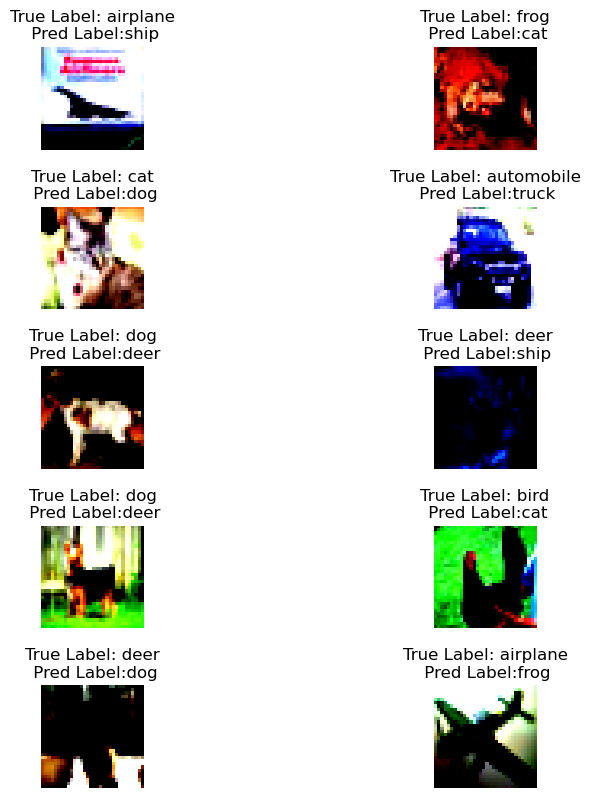

In [24]:
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(8,8),squeeze=False )
fig.tight_layout(h_pad=2)
idx = 0
keys_list = iter(list(bn_misclassified_preds.keys()))
for i in range(5):
    for j in range(2):
        idx = next(keys_list)
        axs[i, j].imshow(np.transpose(bn_misclassified_preds[idx][0], (1,2,0)), cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'True Label: {mapper.get(bn_misclassified_preds[idx][1].item())}\n Pred Label:{mapper.get(bn_misclassified_preds[idx][2].item())}')
        

### Group Normalization

In [25]:
gn_model = get_model('GN').to(device)

In [26]:
summary(gn_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]             330
            Conv2d-3           [-1, 12, 32, 32]              84
         MaxPool2d-4           [-1, 12, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,744
         GroupNorm-6           [-1, 16, 16, 16]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 32, 16, 16]             544
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 32, 8, 8]           9,248
        GroupNorm-12             [-1, 32, 8, 8]              64
           Conv2d-13             [-1, 64, 8, 8]          18,496
           Conv2d-14             [-1, 6

In [27]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(gn_model.parameters(), lr=0.001, momentum=0.9)

In [28]:
gn_train_losses, gn_train_accs, gn_test_losses, gn_test_accs = trainer(gn_model,
                                                                      criterion,
                                                                      optimizer)

Epoch 1/30 - Train Loss: 2.3026 - Train Acc: 0.1050 - Test Loss: 2.3002 - Test Acc: 0.1564
Epoch 2/30 - Train Loss: 2.2871 - Train Acc: 0.1450 - Test Loss: 2.2304 - Test Acc: 0.1608
Epoch 3/30 - Train Loss: 2.0446 - Train Acc: 0.1988 - Test Loss: 1.9492 - Test Acc: 0.2146
Epoch 4/30 - Train Loss: 1.9144 - Train Acc: 0.2308 - Test Loss: 1.9072 - Test Acc: 0.2317
Epoch 5/30 - Train Loss: 1.8665 - Train Acc: 0.2521 - Test Loss: 1.8429 - Test Acc: 0.2801
Epoch 6/30 - Train Loss: 1.8216 - Train Acc: 0.2855 - Test Loss: 1.7618 - Test Acc: 0.3347
Epoch 7/30 - Train Loss: 1.7016 - Train Acc: 0.3481 - Test Loss: 1.6195 - Test Acc: 0.3774
Epoch 8/30 - Train Loss: 1.5964 - Train Acc: 0.3883 - Test Loss: 1.5352 - Test Acc: 0.4155
Epoch 9/30 - Train Loss: 1.5244 - Train Acc: 0.4190 - Test Loss: 1.4692 - Test Acc: 0.4348
Epoch 10/30 - Train Loss: 1.4643 - Train Acc: 0.4466 - Test Loss: 1.4338 - Test Acc: 0.4475
Epoch 11/30 - Train Loss: 1.4129 - Train Acc: 0.4698 - Test Loss: 1.4134 - Test Acc: 0.47

In [29]:
gn_misclassified_preds = get_misclassified_images(gn_model, device, testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

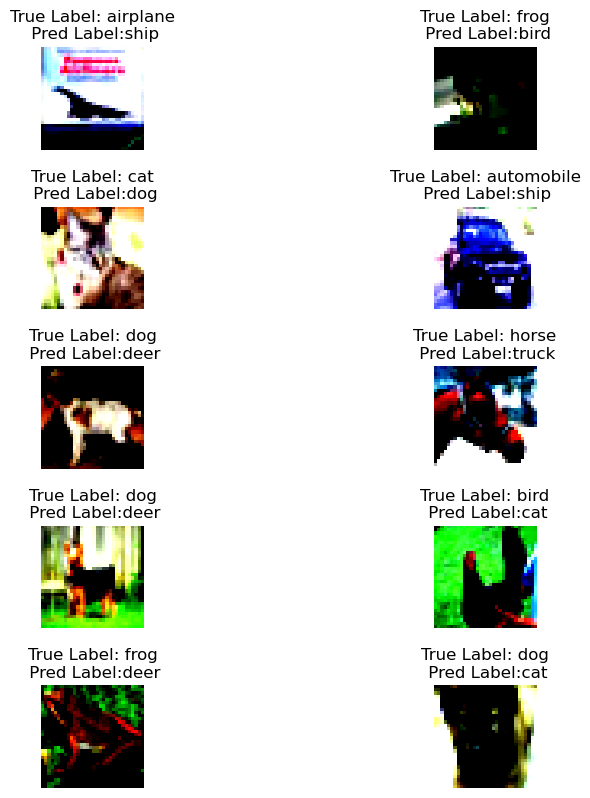

In [30]:
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(8,8),squeeze=False )
fig.tight_layout(h_pad=2)
idx = 0
keys_list = iter(list(gn_misclassified_preds.keys()))
for i in range(5):
    for j in range(2):
        idx = next(keys_list)
        axs[i, j].imshow(np.transpose(gn_misclassified_preds[idx][0], (1,2,0)), cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'True Label: {mapper.get(gn_misclassified_preds[idx][1].item())}\n Pred Label:{mapper.get(gn_misclassified_preds[idx][2].item())}')
        

### Layer Normalization

In [31]:
ln_model = get_model("LN").to(device)

In [32]:
summary(ln_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]             330
            Conv2d-3           [-1, 12, 32, 32]              84
         MaxPool2d-4           [-1, 12, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,744
         LayerNorm-6           [-1, 16, 16, 16]           8,192
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
         MaxPool2d-9             [-1, 16, 8, 8]               0
           Conv2d-10             [-1, 16, 8, 8]             272
           Conv2d-11             [-1, 16, 8, 8]           2,320
        LayerNorm-12             [-1, 16, 8, 8]           2,048
           Conv2d-13             [-1, 32, 8, 8]           4,640
           Conv2d-14             [-1, 6

In [33]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ln_model.parameters(), lr=0.001, momentum=0.9)

In [34]:
ln_train_losses, ln_train_accs, ln_test_losses, ln_test_accs = trainer(ln_model,
                                                                      criterion,
                                                                      optimizer)

Epoch 1/30 - Train Loss: 2.2938 - Train Acc: 0.1293 - Test Loss: 2.2559 - Test Acc: 0.1635
Epoch 2/30 - Train Loss: 2.1106 - Train Acc: 0.1909 - Test Loss: 2.0014 - Test Acc: 0.2002
Epoch 3/30 - Train Loss: 1.9596 - Train Acc: 0.2183 - Test Loss: 1.9802 - Test Acc: 0.2253
Epoch 4/30 - Train Loss: 1.8769 - Train Acc: 0.2550 - Test Loss: 1.8192 - Test Acc: 0.2852
Epoch 5/30 - Train Loss: 1.7688 - Train Acc: 0.3024 - Test Loss: 1.7059 - Test Acc: 0.3279
Epoch 6/30 - Train Loss: 1.6940 - Train Acc: 0.3344 - Test Loss: 1.6616 - Test Acc: 0.3465
Epoch 7/30 - Train Loss: 1.6521 - Train Acc: 0.3557 - Test Loss: 1.6052 - Test Acc: 0.3763
Epoch 8/30 - Train Loss: 1.6189 - Train Acc: 0.3684 - Test Loss: 1.5764 - Test Acc: 0.3915
Epoch 9/30 - Train Loss: 1.5883 - Train Acc: 0.3830 - Test Loss: 1.5392 - Test Acc: 0.4092
Epoch 10/30 - Train Loss: 1.5629 - Train Acc: 0.3988 - Test Loss: 1.5920 - Test Acc: 0.3899
Epoch 11/30 - Train Loss: 1.5318 - Train Acc: 0.4125 - Test Loss: 1.4947 - Test Acc: 0.42

In [36]:
ln_misclassified_preds = get_misclassified_images(ln_model, device, testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

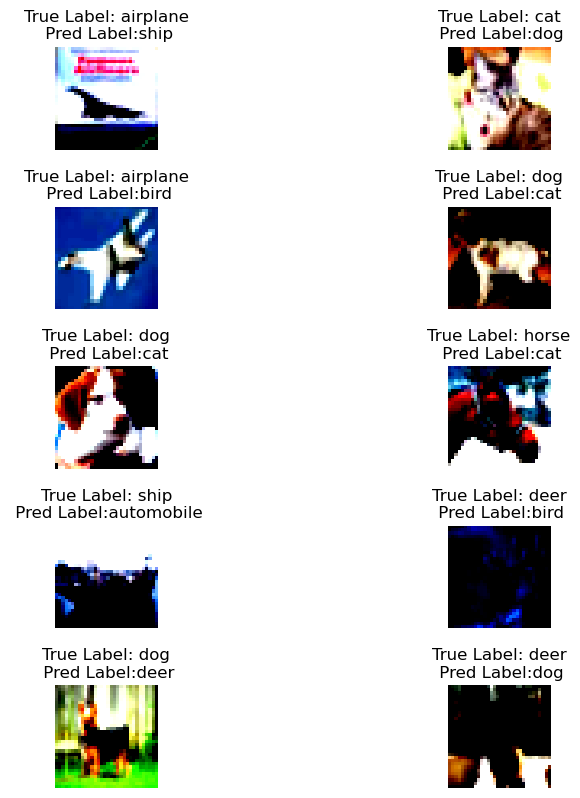

In [37]:
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(8,8),squeeze=False )
fig.tight_layout(h_pad=2)
idx = 0
keys_list = iter(list(ln_misclassified_preds.keys()))
for i in range(5):
    for j in range(2):
        idx = next(keys_list)
        axs[i, j].imshow(np.transpose(ln_misclassified_preds[idx][0], (1,2,0)), cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'True Label: {mapper.get(ln_misclassified_preds[idx][1].item())}\n Pred Label:{mapper.get(ln_misclassified_preds[idx][2].item())}')
        

### Epoch vs Loss for 3 Normalization Techniques

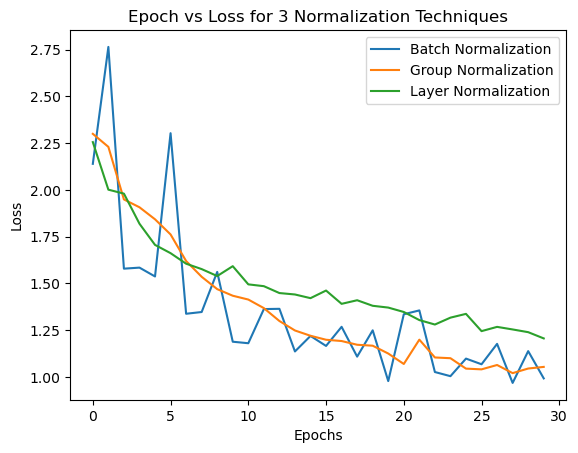

In [42]:
plt.plot(bn_test_losses, label="Batch Normalization")
plt.plot(gn_test_losses, label="Group Normalization")
plt.plot(ln_test_losses, label="Layer Normalization")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Epoch vs Loss for 3 Normalization Techniques")
plt.legend()

### Epoch vs Accuracy for 3 Normalization Techniques

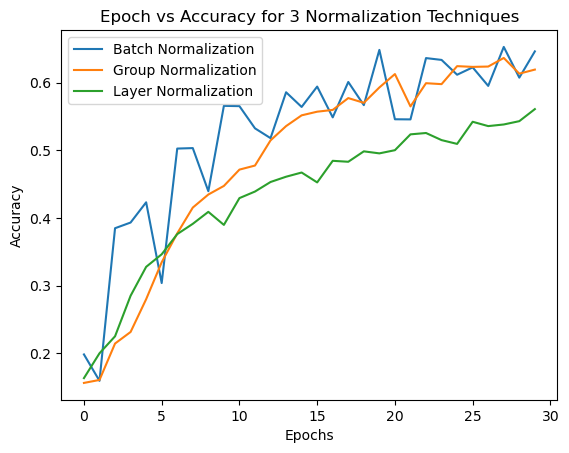

In [44]:
plt.plot(bn_test_accs, label="Batch Normalization")
plt.plot(gn_test_accs, label="Group Normalization")
plt.plot(ln_test_accs, label="Layer Normalization")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Epoch vs Accuracy for 3 Normalization Techniques")
plt.legend()